In [1]:
import sr_signal
import database
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import product
import math
from matplotlib.patches import Rectangle
from graphviz import Digraph
import os
import pickle

# This is for jupyter to recognize changes in external files without restarting kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Simulation data
path = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output"
scenarios = ["S7_IRREG1_K1", "S8_IRREG1_K0d7", "S9_IRREG1_K0d5", "S10_IRREG1_K1d35", "S11_IRREG2_K1"]
sensor_names = ["B1_right"]

fs = 50  # Hz

# segmentation
seg_len_sec = 16.0
seg_hop_sec = 1.6  # 90% overlap
seg_len_samples = int(seg_len_sec * fs)  # 800
seg_hop_samples = int(seg_hop_sec * fs)  # 80

In [3]:
scenario_data = {}

for scenario in scenarios:
    scenario_data[scenario] = sr_signal.load_data(path, scenario)

In [4]:
scenario = "S7_IRREG1_K1"
sensor_name = sensor_names[0]
segment = 32  # max. 65

acceleration, time, dist = scenario_data[scenario][sensor_name]

segments = []  # list of (seg_signal, seg_start_time, seg_index) tuples

N = len(acceleration)
seg_index = 0
start = 0
while start + seg_len_samples <= N:
    end = start + seg_len_samples
    seg_signal = acceleration[start:end]
    seg_start_time = time[start]  # absolute time from simulation start
    segments.append((seg_signal, seg_start_time, seg_index))
    seg_index += 1
    start += seg_hop_samples

seg_signal, seg_start_time, seg_index = segments[segment]

stft_magnitude, peaks, frame_times, freqs = sr_signal.process_signal(seg_signal)

In [5]:
# segment data
print(f'Number of segments per simulation = {len(segments)}, expected = {math.floor((N-seg_len_samples)/seg_hop_samples+1)}')
print(stft_magnitude.shape)  # (nr. of frequencies, frames)

Number of segments per simulation = 66, expected = 66
(129, 29)


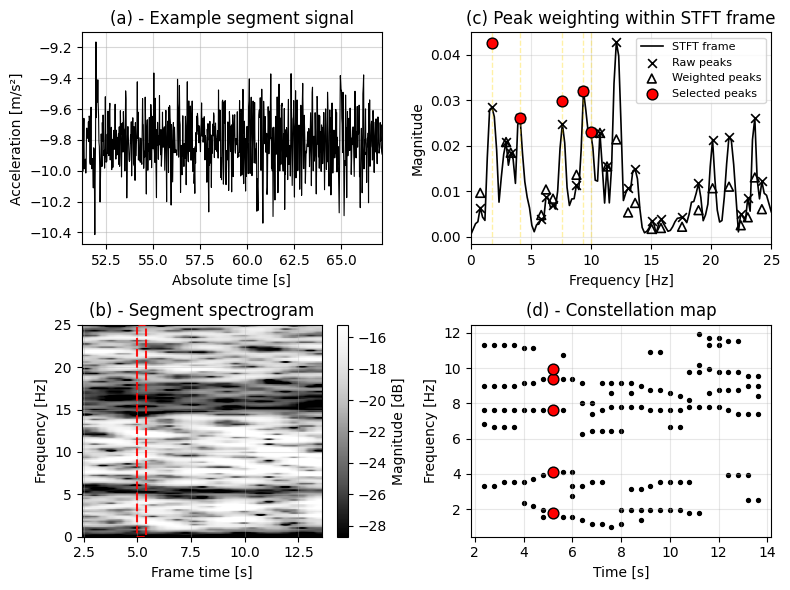

In [6]:
# Data
frame_idx = 7
frame = stft_magnitude[:, frame_idx]
window = 3
half_window = window // 2
local_max = np.zeros(len(frame), dtype=bool)

for i in range(half_window, len(frame) - half_window):
    if frame[i] == np.max(frame[i-half_window:i+half_window+1]) and frame[i] > 0:
        local_max[i] = True

_, band_masks, band_weights = sr_signal.peaks(stft_magnitude, frame_times, 5, freqs)

peak_indices = np.where(local_max)[0]
peak_magnitudes = frame[peak_indices]

weights = np.ones(len(peak_indices))
for band_name, band_mask in band_masks.items():
    weights[band_mask[peak_indices]] = band_weights[band_name]

weighted_magnitudes = peak_magnitudes * weights

peaks_sorted = sorted(peaks, key=lambda p: p[1])
start_idx = frame_idx * 5
end_idx = start_idx + 5

###########################################################################

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# =========================
# (a) Time-domain signal — TOP LEFT
# =========================
ax_t = axs[0, 0]

seg_time = seg_start_time + np.arange(seg_len_samples) * (time[1] - time[0])

ax_t.plot(seg_time, seg_signal, color="black", linewidth=0.8)
ax_t.set_ylabel("Acceleration [m/s²]")
ax_t.set_xlabel("Absolute time [s]")
ax_t.set_xlim(seg_time[0],seg_time[-1])
ax_t.set_title("(a) - Example segment signal")
ax_t.grid(True, alpha=0.5)


# =========================
# Spectrogram only — BOTTOM LEFT
# =========================
ax_spec = axs[1, 0]

dt = frame_times[1] - frame_times[0]

frame_start = frame_times[frame_idx] - dt / 2
frame_end   = frame_times[frame_idx] + dt / 2

mag_db = 10 * np.log10(stft_magnitude + 1e-12)
vmin = np.percentile(mag_db, 5)
vmax = np.percentile(mag_db, 95)

im = ax_spec.imshow(
    mag_db,
    aspect="auto",
    origin="lower",
    extent=[frame_times[0], frame_times[-1], freqs[0], freqs[-1]],
    vmin=vmin,
    vmax=vmax,
    cmap="Greys_r"
)

rect = Rectangle(
    (frame_start, freqs[0]),      # (x, y)
    dt,                           # width  (time)
    freqs[-1] - freqs[0],         # height (frequency)
    linewidth=1.5,
    edgecolor="red",
    facecolor="none",
    linestyle="--",
    alpha=0.9,
    zorder=5
)

ax_spec.add_patch(rect)

ax_spec.set_xlabel("Frame time [s]")
ax_spec.set_ylabel("Frequency [Hz]")
ax_spec.set_title("(b) - Segment spectrogram")
ax_spec.grid(True, alpha=0.3)

fig.colorbar(im, ax=ax_spec, label="Magnitude [dB]")


# =========================
# Peak weighting + selection — TOP RIGHT
# =========================
ax_pw = axs[0, 1]

# Top-N peak selection
top_indices = np.argsort(-weighted_magnitudes)[:5]

# Masks
selected_mask = np.zeros(len(peak_indices), dtype=bool)
selected_mask[top_indices] = True
non_selected_mask = ~selected_mask

# 1) Full STFT frame
ax_pw.plot(
    freqs,
    frame,
    color="black",
    linewidth=1.2,
    label="STFT frame"
)

# 2) Raw peaks (BLUE)
ax_pw.scatter(
    freqs[peak_indices],
    frame[peak_indices],
    marker="x",
    color="black",
    s=40,
    linewidths=1.2,
    zorder=3,
    label="Raw peaks"
)

# 3) Weighted peaks – non-selected (RED)
ax_pw.scatter(
    freqs[peak_indices[non_selected_mask]],
    weighted_magnitudes[non_selected_mask],
    marker="^",
    facecolors="none",  # since it is a filled big marker, make it prettier with removing filling
    edgecolor="black",
    s=40,
    linewidths=1.2,
    zorder=4,
    label="Weighted peaks"
)

# 4) Weighted peaks – selected
ax_pw.scatter(
    freqs[peak_indices[selected_mask]],
    weighted_magnitudes[selected_mask],
    marker="o",
    facecolors="red",
    edgecolors="black",
    s=60,
    zorder=5,
    label="Selected peaks"
)

# 5) Vertical dashed lines for selected peaks
for f in freqs[peak_indices[selected_mask]]:
    ax_pw.axvline(
        f,
        color="gold",
        linestyle="--",
        alpha=0.35,
        linewidth=1
    )

ax_pw.set_xlabel("Frequency [Hz]")
ax_pw.set_ylabel("Magnitude")
ax_pw.set_xlim(freqs[0],freqs[-1])
ax_pw.set_title("(c) Peak weighting within STFT frame")

ax_pw.grid(True, alpha=0.3)
ax_pw.legend(fontsize=8)


# =========================
# Peaks in time–frequency plane — BOTTOM RIGHT
# =========================
ax_tf = axs[1, 1]

peak_freqs = np.array([p[0] for p in peaks])
peak_times = np.array([p[1] for p in peaks])
peak_freqs_sorted = np.array([p[0] for p in peaks_sorted])
peak_times_sorted = np.array([p[1] for p in peaks_sorted])

ax_tf.scatter(peak_times, peak_freqs, s=8, color="black")

ax_tf.scatter(
    peak_times_sorted[start_idx:end_idx],
    peak_freqs_sorted[start_idx:end_idx],
    s=60,
    facecolors="red",
    edgecolors="black",
    zorder=3,
    label=f"Frame {frame_idx} selected peaks"
)

ax_tf.set_xlabel("Time [s]")
ax_tf.set_ylabel("Frequency [Hz]")
ax_tf.set_title("(d) - Constellation map")
ax_tf.grid(True, alpha=0.3)


fig.tight_layout()
plt.show()

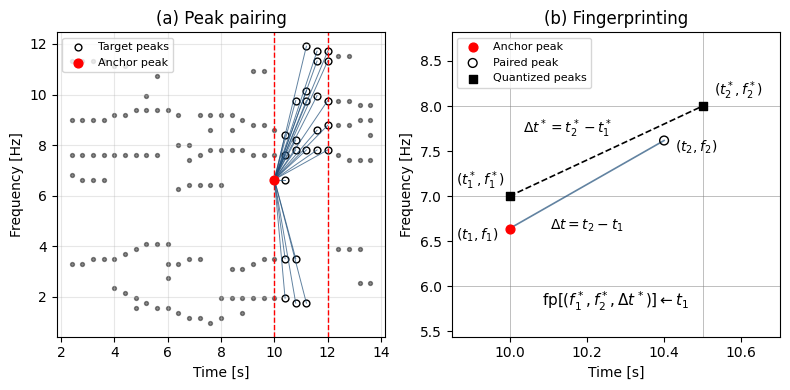

34.0


In [11]:
# -----------------------
# Parameters
# -----------------------
time_window_sec = 2.0

# -----------------------
# Sort peaks by time
# -----------------------
peaks_sorted = sorted(peaks, key=lambda p: p[1])
peak_freqs = np.array([p[0] for p in peaks_sorted])
peak_times = np.array([p[1] for p in peaks_sorted])

# -----------------------
# Choose anchor
# -----------------------
anchor_idx = 99  # <= 144
t1 = peak_times[anchor_idx]
f1 = peak_freqs[anchor_idx]

# -----------------------
# Identify target peaks
# -----------------------
is_target = (peak_times > t1) & (peak_times <= t1 + time_window_sec)
target_times = peak_times[is_target]
target_freqs = peak_freqs[is_target]

# Choose ONE target for zoomed plot
target_idx = 1
t2 = target_times[target_idx]
f2 = target_freqs[target_idx]
delta_t = t2 - t1

# -----------------------
# Create figure
# -----------------------
fig, (ax_left, ax_right) = plt.subplots(
    1, 2, figsize=(8, 4), gridspec_kw={"width_ratios": [1, 1]}
)

# =====================================================
# LEFT: Constellation + pairing window
# =====================================================
ax_left.scatter(
    peak_times, peak_freqs,
    s=8, color="black", alpha=0.45
)

ax_left.scatter(
    target_times, target_freqs,
    s=24,
    facecolors="white",
    edgecolors="black",
    linewidths=1.0,
    label="Target peaks"
)

# ax_left.scatter(
#     target_times, target_freqs,
#     s=20, color="tab:blue", label="Target peaks"
# )

ax_left.scatter(
    t1, f1,
    s=40, color="red", zorder=5, label="Anchor peak"
)

# Time window
ax_left.axvline(t1, color="red", linestyle="--", linewidth=1)
ax_left.axvline(t1 + time_window_sec, color="red", linestyle="--", linewidth=1)

# Connections
for t, f in zip(target_times, target_freqs):
    ax_left.plot(
        [t1, t], [f1, f],
        color="#1f4e79", linewidth=0.7, alpha=0.7
    )

ax_left.set_xlabel("Time [s]")
ax_left.set_ylabel("Frequency [Hz]")
ax_left.set_title("(a) Peak pairing")
ax_left.grid(True, alpha=0.3)
ax_left.legend(fontsize=8, loc="upper left")

# =====================================================
# RIGHT: Zoomed explanation of one fingerprint
# =====================================================
# --- Quantization parameters (from algorithm)
freq_quantization_hz = 1.0
time_quantization_sec = 0.5
time_window_sec = 2.0

f1_bin = int(round(f1 / freq_quantization_hz))
f2_bin = int(round(f2 / freq_quantization_hz))
dt_bin = int(round(delta_t / time_quantization_sec))

f1_q = f1_bin * freq_quantization_hz
f2_q = f2_bin * freq_quantization_hz
dt_q = dt_bin * time_quantization_sec
t2_q = t1 + dt_q

# --- Axis limits (tight zoom)
t_min = t1 - 0.15
t_max = t1 + time_window_sec * 0.35
f_min = min(f1, f2) - 1.2
f_max = max(f1, f2) + 1.2

ax = ax_right

# --- Draw quantization grid
for f in np.arange(np.floor(f_min), np.ceil(f_max) + 1, freq_quantization_hz):
    ax.axhline(f, color="gray", alpha=0.7, linewidth=0.5)

for dt in np.arange(0, time_window_sec + time_quantization_sec,
                    time_quantization_sec):
    ax.axvline(t1 + dt, color="gray", alpha=0.7, linewidth=0.5)

# --- Continuous points
# ax.scatter([t1, t2], [f1, f2],
#            color=["red", "tab:blue"],
#            s=50, zorder=4, label="Continuous values")

ax.scatter(
    [t1], [f1],
    color="red", s=40, zorder=5, label="Anchor peak"
)

ax.scatter(
    [t2], [f2],
    marker="o",
    facecolors="none",
    edgecolors="black",
    s=40,
    zorder=4,
    label="Paired peak"
)

ax.plot([t1, t2], [f1, f2],
        color="#1f4e79", linewidth=1.2, alpha=0.7)

# --- Quantized (snapped) points
ax.scatter([t1, t2_q], [f1_q, f2_q],
           marker="s", s=40, color="black",
           zorder=5, label="Quantized peaks")

ax.plot([t1, t2_q], [f1_q, f2_q],
        color="black", linewidth=1.2, linestyle="--")

# --- Annotations: coordinates
ax.annotate(r"$(t_1, f_1)$",
            (t1, f1),
            textcoords="offset points",
            xytext=(-8, -8),
            ha="right")

ax.annotate(r"$(t_2, f_2)$",
            (t2, f2),
            textcoords="offset points",
            xytext=(8, -8),
            ha="left")

ax.annotate(r"$(t_1^*, f_1^*)$",
            (t1, f1_q),
            textcoords="offset points",
            xytext=(-3, 8),
            ha="right")

ax.annotate(r"$(t_2^*, f_2^*)$",
            (t2_q, f2_q),
            textcoords="offset points",
            xytext=(8, 8),
            ha="left")

# --- Δt annotation
ax.text((t1 + t2) / 2,
        (f1 + f2) / 2 - 0.5,
        r"$\Delta t = t_2 - t_1$",
        ha="center", fontsize=10)

ax.text((t1 + t2) / 2-0.05,
        (f1_q + f2_q) / 2 + 0.2,
        r"$\Delta t^* = t_2^* - t_1^*$",
        ha="center", fontsize=10)

# --- Fingerprint equation
ax.text(0.5, 0.1,
        rf"$\mathrm{{fp}}[(f_1^*,f_2^*,\Delta t^*)] \leftarrow t_1$",
        transform=ax.transAxes,
        ha="center", fontsize=11)

# --- Styling
ax.set_xlim(t_min, t_max)
ax.set_ylim(f_min, f_max)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")
ax.set_title("(b) Fingerprinting")
ax.grid(False)
ax.legend(fontsize=8, loc="upper left")

plt.tight_layout()
plt.show()

print(f1/0.1953125)

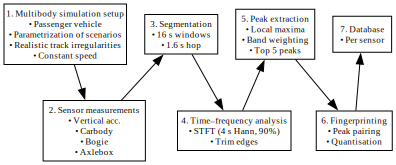

In [9]:
dot = Digraph(name = "flowchart", format="svg")
dot.attr(rankdir="TD")
dot.attr("node", shape="box", fontsize="9", align="center")
dot.node("1", "1. Multibody simulation setup\n"
              "• Passenger vehicle\n"
              "• Parametrization of scenarios\n"
              "• Realistic track irregularities\n"
              "• Constant speed")

dot.node("2", "2. Sensor measurements\n"
              "• Vertical acc. \n"
              "• Carbody\n"
              "• Bogie\n"
              "• Axlebox")

dot.node("3", "3. Segmentation\n"
              "• 16 s windows\n"
              "• 1.6 s hop")

dot.node("4", "4. Time–frequency analysis\n"
              "• STFT (4 s Hann, 90%)\n"
              "• Trim edges")

dot.node("5", "5. Peak extraction\n"
              "• Local maxima\n"
              "• Band weighting\n"
              "• Top 5 peaks")

dot.node("6", "6. Fingerprinting\n"
              "• Peak pairing\n"
              "• Quantisation")

dot.node("7", "7. Database\n"
              "• Per sensor\n")

# --- Staggering via subgraphs ---
# Odd nodes go slightly up, even nodes go slightly down
with dot.subgraph() as s:
    s.attr(rank="same")
    s.node("1")
    s.node("3")
    s.node("5")
    s.node("7")

with dot.subgraph() as s:
    s.attr(rank="same")
    s.node("2")
    s.node("4")
    s.node("6")

# Connect main flow
dot.edge("1", "2")
dot.edge("2", "3")
dot.edge("3", "4")
dot.edge("4", "5")
dot.edge("5", "6")
dot.edge("6", "7")

dot

In [64]:
dot.render(
    filename="flowchart",
    directory=str(r'C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\03 Figures'),
    cleanup=True,   # removes intermediate .dot file
    view=False
)

'C:\\Users\\prife\\OneDrive - KTH\\KTH\\04 Research\\01 Conferences\\2026\\Railways\\03 Figures\\flowchart.svg'

In [81]:
def match_unique_hashes(sample_fps, hash_to_entries):
    """
    Score by number of distinct hash keys shared with each scenario.
    """
    scenario_hashes = defaultdict(set)

    for h in sample_fps.keys():
        if h not in hash_to_entries:
            continue
        for scenario_name, seg_idx, anchor_time_db, frame_time_db in hash_to_entries[h]:
            scenario_hashes[scenario_name].add(h)

    scores = {sc: len(hashes) for sc, hashes in scenario_hashes.items()}
    return scores

def conf_mat_sep_by_method(method_name, sensor_names, confusion_dict, grouped_labels):
    sensor_names_paper = ["(a) - carbody @ bogie", "(b) - carbody @ cab", "(c) - bogie", "(d) - axlebox"]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for idx, (ax, sensor) in enumerate(zip(axes, sensor_names)):
        confusion = confusion_dict[method_name][sensor]
        im = ax.imshow(confusion, cmap="Greys", vmin=0, vmax=confusion.max())

        S = confusion.shape[0]

        # annotate cells
        thresh = confusion.max() / 2
        for i in range(S):
            for j in range(S):
                val = confusion[i, j]
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", color="white" if confusion[i, j] > thresh else "black")

        # x-axis
        ax.set_xticks(range(S))
        ax.set_xticklabels(grouped_labels, rotation=45, ha="right")
        ax.set_xlabel("Predicted scenario")

        # y-axis
        ax.set_yticks(range(S))
        if idx == 0:
            ax.set_yticklabels(grouped_labels)
            ax.set_ylabel("True scenario")
        else:
            ax.set_yticklabels([])

        ax.set_title(sensor_names_paper[idx])
    plt.show()

Loading cached results...
[[31  2  0]
 [39 60  0]
 [21  3  9]]
[[32  1  0]
 [46 53  0]
 [18  2 13]]
[[33  0  0]
 [52 47  0]
 [33  0  0]]
[[33  0  0]
 [38 61  0]
 [ 0  3 30]]


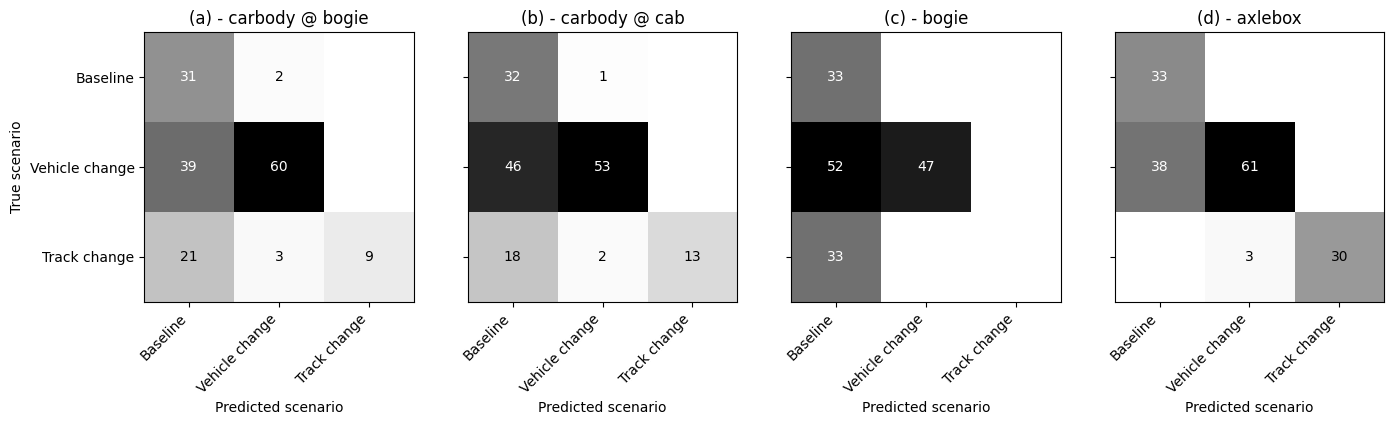

In [82]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_1.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_sep = data["confusion_dict"]
    accuracy_dict_sep = data["accuracy_dict"]

conf_mat_sep_by_method(
    method_name="unique",           # or whatever matcher you want
    sensor_names=["carbody_B1", "carbody_cab", "B1_right", "WS1_right"],   # list of sensors
    confusion_dict=confusion_dict_sep,
    grouped_labels=["Baseline", "Vehicle change", "Track change"]
)

Loading cached results...


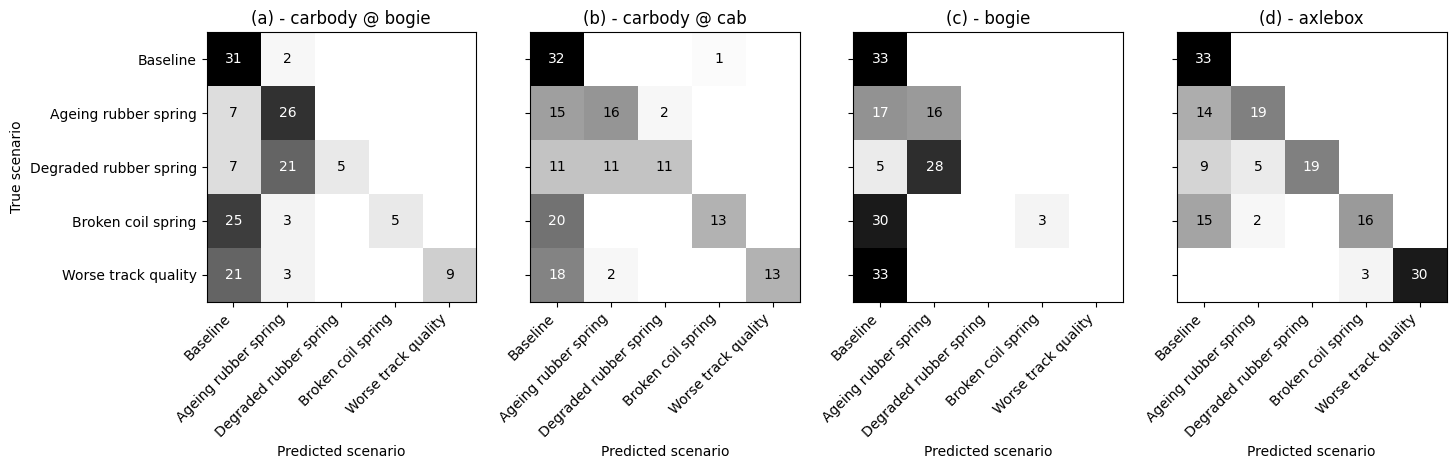

In [29]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_2.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_grad = data["confusion_dict"]
    accuracy_dict_grad = data["accuracy_dict"]

conf_mat_sep_by_method(
    method_name="unique",           # or whatever matcher you want
    sensor_names=["carbody_B1", "carbody_cab", "B1_right", "WS1_right"],   # list of sensors
    confusion_dict=confusion_dict_grad,
    grouped_labels=["Baseline", "Ageing rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]
)

In [88]:
def conf_mat_noise(sensor_name, confusion_dict):
    matcher = "unique"
    all_keys = list(next(iter(next(iter(confusion_dict.values())).values())).keys())
    snr_values = [all_keys[0]] + [all_keys[1]] + [all_keys[2]] # 40, 20
    # grouped_labels = ["Baseline", "Ageing rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]
    grouped_labels = ["Baseline", "Vehicle change", "Track change"]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for idx, ax in enumerate(axes):

        if idx == 0:
            confusion = confusion_dict_sep[matcher][sensor_name]
        else:
            snr = snr_values[idx - 1]
            confusion = confusion_dict[matcher][sensor_name][snr]

        im = ax.imshow(confusion, cmap="Greys", vmin=0, vmax=confusion.max())

        S = confusion.shape[0]

        # annotate cells
        thresh = confusion.max() / 2
        for i in range(S):
            for j in range(S):
                val = confusion[i, j]
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", color="white" if confusion[i, j] > thresh else "black")

        # x-axis
        ax.set_xticks(range(S))
        ax.set_xticklabels(grouped_labels, rotation=45, ha="right")
        ax.set_xlabel("Predicted scenario")

        if idx == 0:
            ax.set_title(f'(a) - without noise')
        else:
            ax.set_title(f'({chr(ord('a') + idx)}) - SNR = {snr}')


        # y-axis
        ax.set_yticks(range(S))
        if idx == 0:
            ax.set_yticklabels(grouped_labels)
            ax.set_ylabel("True scenario")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    # plt.tight_layout()
    plt.show()

Loading cached results...


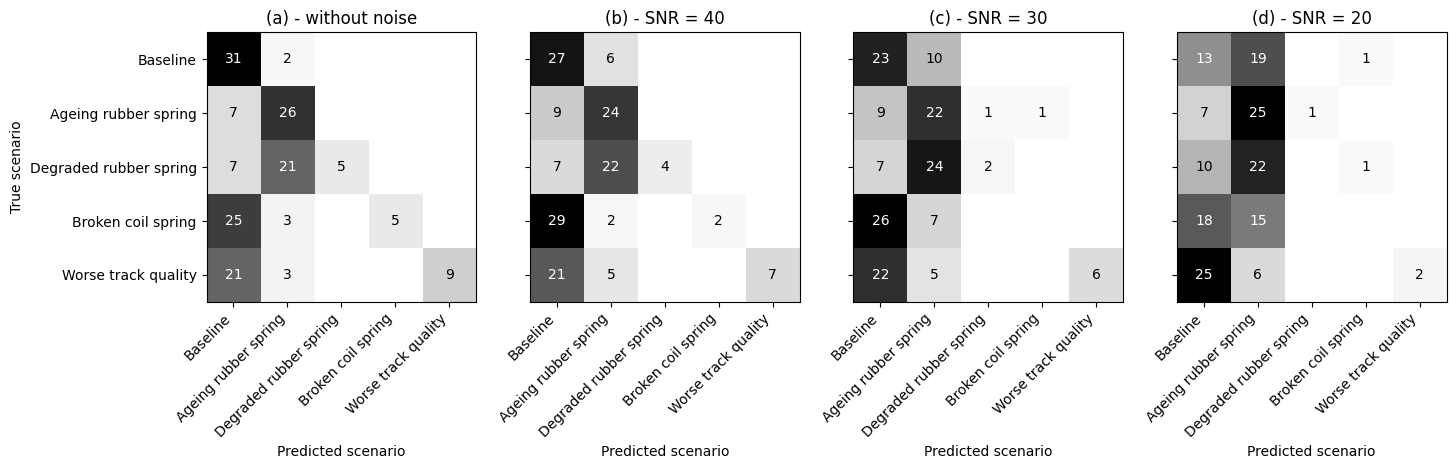

In [64]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_3.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_noise = data["confusion_dict"]
    accuracy_dict_noise = data["accuracy_dict"]

sensor_names=["carbody_B1", "carbody_cab", "B1_right", "WS1_right"]

conf_mat_noise(sensor_names[0], confusion_dict_noise)

In [89]:
def refactor_to_exp1(conf_dict):
    collapsed_dict = {}
    for method, sensors in conf_dict.items():
        collapsed_dict[method] = {}
        for sensor, snrs in sensors.items():
            collapsed_dict[method][sensor] = {}
            for snr, matrix in snrs.items():
                # Create a new 3x3 matrix
                new_matrix = np.zeros((3, 3), dtype=matrix.dtype)

                # Row 0 → original label 0
                new_matrix[0, 0] = matrix[0, 0]  # stays the same
                new_matrix[0, 1] = matrix[0, 1] + matrix[0, 2] + matrix[0, 3]  # collapse 2,3,4
                new_matrix[0, 2] = matrix[0, 4]  # stays the same

                # Row 1 → original labels 1,2,3 collapsed
                new_matrix[1, 0] = matrix[1, 0] + matrix[2, 0] + matrix[3, 0]
                new_matrix[1, 1] = matrix[1, 1] + matrix[1, 2] + matrix[1, 3] + \
                                   matrix[2, 1] + matrix[2, 2] + matrix[2, 3] + \
                                   matrix[3, 1] + matrix[3, 2] + matrix[3, 3]
                new_matrix[1, 2] = matrix[1, 4] + matrix[2, 4] + matrix[3, 4]

                # Row 2 → original label 4
                new_matrix[2, 0] = matrix[4, 0]
                new_matrix[2, 1] = matrix[4, 1] + matrix[4, 2] + matrix[4, 3]
                new_matrix[2, 2] = matrix[4, 4]

                collapsed_dict[method][sensor][snr] = new_matrix
    return collapsed_dict

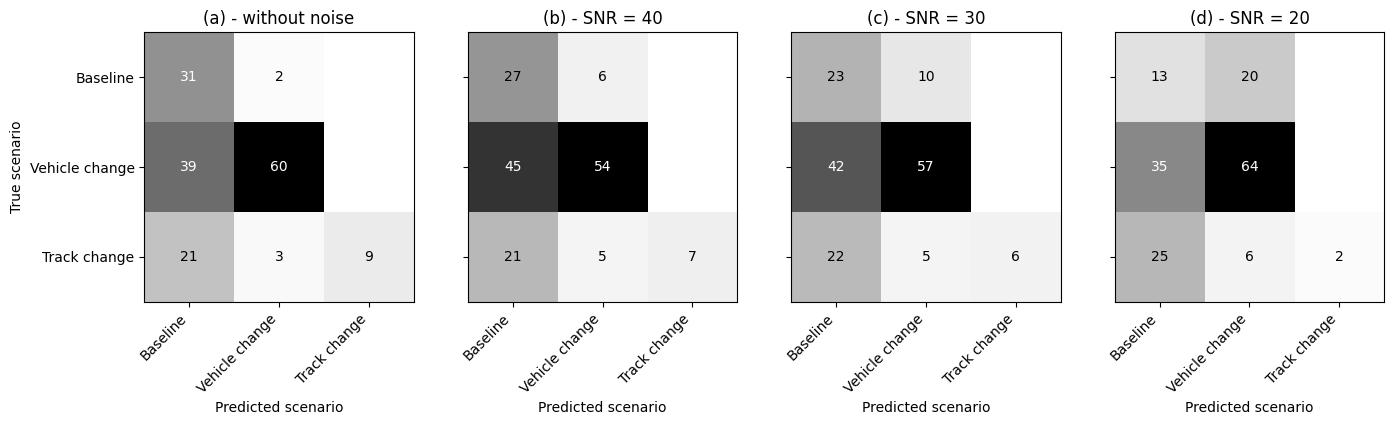

In [145]:
confusion_dict_noise_red = refactor_to_exp1(confusion_dict_noise)
conf_mat_noise(sensor_names[0], confusion_dict_noise_red)

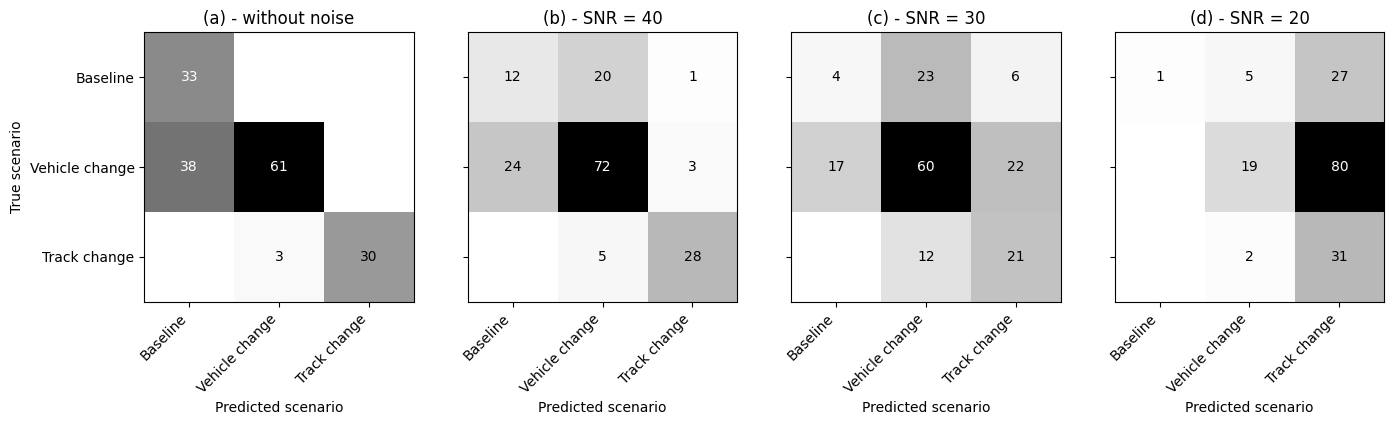

In [147]:
conf_mat_noise(sensor_names[3], confusion_dict_noise_red)

In [143]:
def plot_scenario_accuracy_vs_noise(sensor_names, confusion_dict):
    matcher = "unique"
    grouped_labels = ["Baseline", "Vehicle change", "Track change"]

    # Extract SNR levels (ordered)
    all_keys = list(next(iter(next(iter(confusion_dict.values())).values())).keys())
    snr_values = [all_keys[0], all_keys[2]]  # e.g. [40, 20]

    noise_labels = ["No noise"] + [f"SNR = {snr} dB" for snr in snr_values]
    x = np.arange(len(noise_labels))

    n_scenarios = len(grouped_labels)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

    if n_scenarios == 1:
        axes = [axes]

    # --- Style cycles (shape > style > color)
    marker_cycle = ["o", "s", "^", "D", "v", "P", "X"]
    linestyle_cycle = ["-", "--", "-.", ":"]

    for s_idx, scenario in enumerate(grouped_labels):
        ax = axes[s_idx]

        for i, sensor_name in enumerate(sensor_names):
            recalls = []

            # --- No noise ---
            cm = confusion_dict_sep[matcher][sensor_name]
            recall = cm[s_idx, s_idx] / cm[s_idx, :].sum()
            recalls.append(recall)

            # --- With noise ---
            for snr in snr_values:
                cm = confusion_dict[matcher][sensor_name][snr]
                recall = cm[s_idx, s_idx] / cm[s_idx, :].sum()
                recalls.append(recall)

            ax.plot(
                x,
                recalls,
                color="black",
                marker=marker_cycle[i % len(marker_cycle)],
                linestyle=linestyle_cycle[i % len(linestyle_cycle)],
                linewidth=1.2,
                markersize=7,
                markeredgewidth=1.0,
                label=sensor_name
            )

        ax.set_title(f'({chr(ord('a') + s_idx)}) - {scenario}', fontsize=18)
        ax.set_xticks(x)
        ax.set_xticklabels(noise_labels, rotation=30, fontsize=14)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, linestyle="--", alpha=0.35)

        if s_idx == 0:
            ax.set_ylabel("Recall", fontsize=14)

    # One legend for the whole figure
    fig.legend(
        sensor_names,
        loc="upper center",
        ncol=len(sensor_names),
        frameon=False,
        bbox_to_anchor=(0.5, 1.05),
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

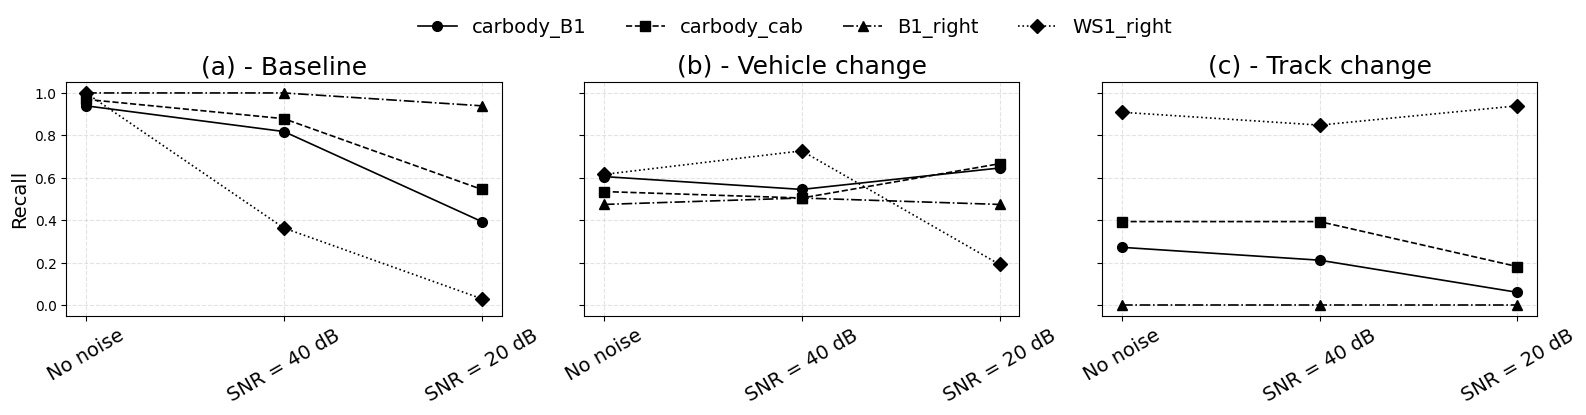

In [144]:
plot_scenario_accuracy_vs_noise(sensor_names, confusion_dict_noise_red)